## Exploring Rossmann Drug Store Sales Data

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (16.0, 8.0)


data = pd.read_csv('/Users/ajbentley/GA-DSI/curriculum/week-12/1.2-autocorrelation\
/assets/datasets/rossmann.csv', skipinitialspace=True, low_memory=False)
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 10 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
Year             1017209 non-null int32
Month            1017209 non-null int32
dtypes: int32(2), int64(7), object(1)
memory usage: 77.6+ MB


Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [2]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month

In [3]:
data['2015-05'];

In [4]:
store1_data = data[data.Store == 1]

### Data Exploration and MINEing

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days. On state holidays the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

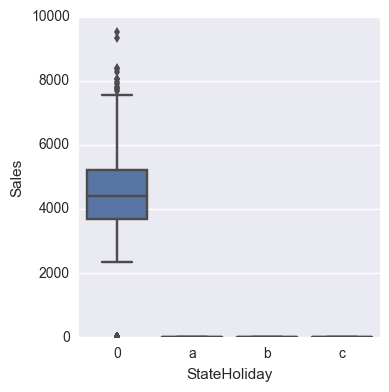

In [7]:
import seaborn as sb
%matplotlib inline

sb.factorplot(x='StateHoliday',
             y='Sales',
             data=store1_data,
             kind='box')


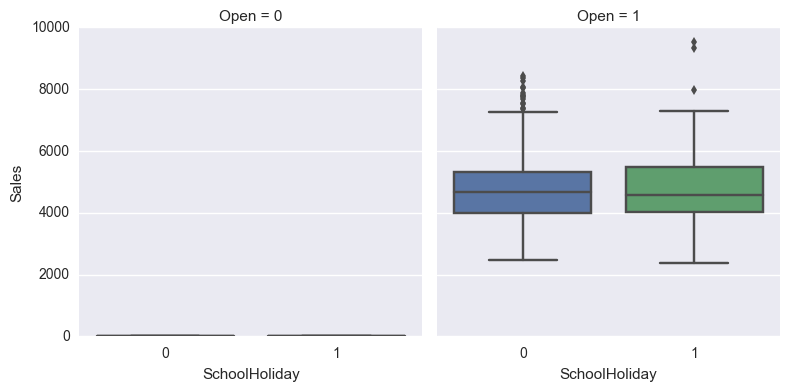

In [8]:
# Can we separate school and state holidays?
# Try separating out days the stores are closed.
sb.factorplot(
    col='Open',
    x='SchoolHoliday',
    y='Sales',
    data=store1_data, 
    kind='box'
)

> Check: See if there is a difference affecting sales on promotion days.

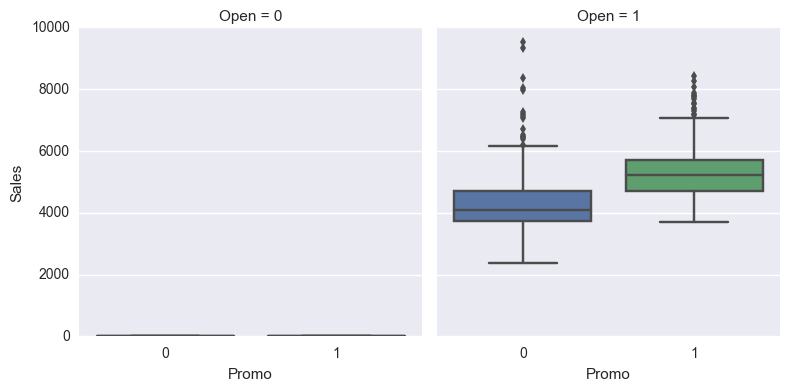

In [10]:
# What happens to sales on promotion days?

sb.factorplot(
    col='Open',
    x='Promo',
    y='Sales',
    data=store1_data, 
    kind='box'
)

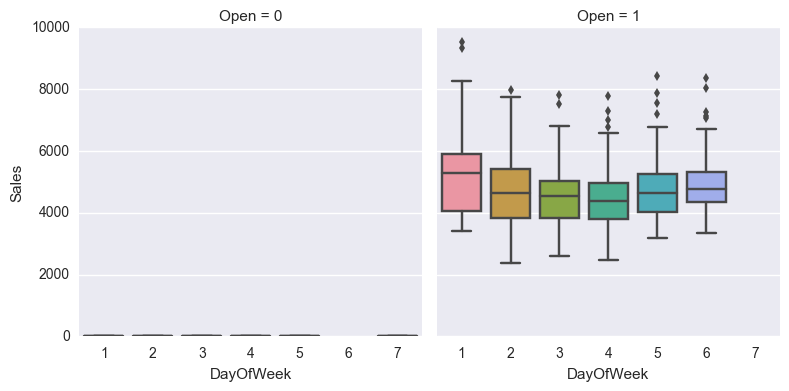

In [12]:
# How about across days of the week?

sb.factorplot(
    col='Open',
    x='DayOfWeek',
    y='Sales',
    data=store1_data, 
    kind='box'
)

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

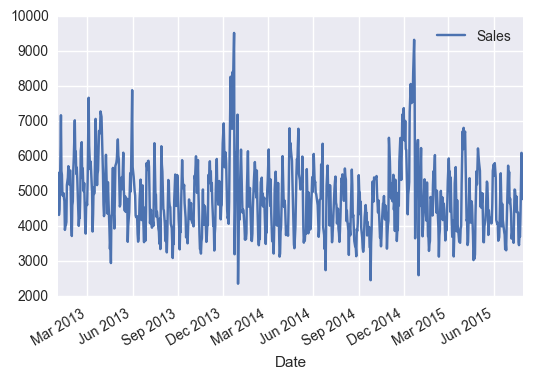

In [14]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data.Open==1]
store1_open_data[['Sales']].plot()

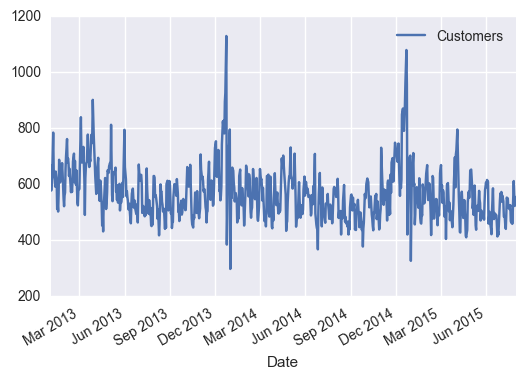

In [15]:
store1_open_data[['Customers']].plot()

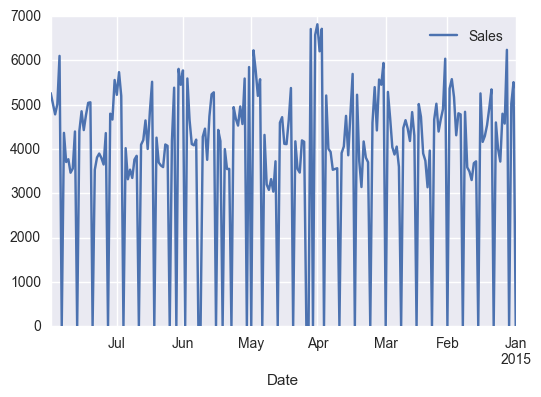

In [21]:
# Let's zoom in on 2015 with index filtering

store1_data_2015 = store1_data['2015']
store1_data_2015[['Sales']].plot()



### Data REFINING Using Time Series Statistics

### Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we do this we with the `autocorr` function.

`autocorr` takes one argument, the `lag` - which is how many prior data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it, while setting `lag` to 10, computes the correlation between every point and the point 10 days earlier.

In [24]:
data['Sales'].resample('D', how='mean').autocorr(lag=7)

/Users/ajbentley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':


0.55748935887396067

### Rolling Averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  We want to know what the mean and median sales were for each month and year.

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - What aggregation to perform: 'mean', 'median', 'sum', etc.

While identifying the monthly averages are useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare late December with the entire month, but perhaps a few days surrounding it. We can do this using rolling averages.

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

In [27]:
# Resample to have the daily average over all stores
daily_store_sales = data[['Sales']].resample('D', how='sum')

pd.rolling_mean(daily_store_sales, window=10, center=False,).head(15)

/Users/ajbentley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  from ipykernel import kernelapp as app
/Users/ajbentley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()


,Sales
Date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,NaN
2013-01-05,NaN
2013-01-06,NaN
2013-01-07,NaN
2013-01-08,NaN
2013-01-09,NaN


`rolling_mean` (as well as `rolling_median`) takes these parameters:
    - the series to aggregate
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date
    - `freq` is on what level to roll-up the averages to (as used in `resample`). Either `D` for day, `M` for month or `A` for year, etc.

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

/Users/ajbentley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=True).mean()
  if __name__ == '__main__':


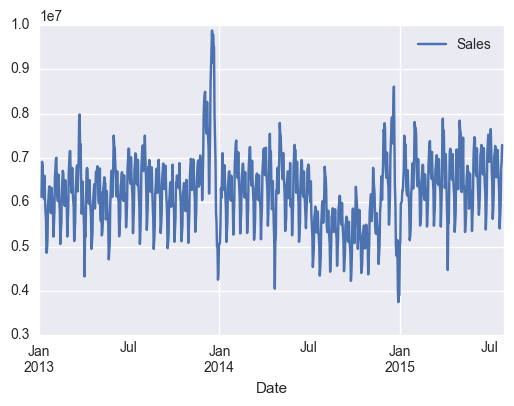

In [29]:
pd.rolling_mean(daily_store_sales, window=10, center=True).plot();

### Pandas Window functions
Pandas `rolling_mean` and `rolling_median` are only two examples of Pandas window function capabilities. Window functions are operate on a set of N consecutive rows (a window) and produce an output.

In addition to `rolling_mean` and `rolling_median`, there are `rolling_sum`, `rolling_min`, `rolling_max`... and many more.

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one arugment, `periods`, which is how many prior rows to use for the difference.


In [30]:
daily_store_sales.diff(periods=1).head()

,Sales
Date,
2013-01-01,NaN
2013-01-02,6852594.0
2013-01-03,-602009.0
2013-01-04,291134.0
2013-01-05,-687361.0


### Pandas expanding functions

In addition to the set of `rolling_*` functions, Pandas also provides a similar collection of `expanding_*` functions, which, instead of using a window of N values, use all values up until that time.

In [ ]:
# computes the average sales, from the first date _until_ the date specified.
pd.expanding_mean(...)

## Independent practice

> Plot the distribution of sales by month and compare the effect of promotions

> Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

> Plot the 15 day rolling mean of customers in the stores

> Identify the date with largest drop in average sales from the same date in the previous month

> Compute the total sales up until Dec. 2014

> When were the largest differences between 15-day moving/rolling averages?
> HINT: Using `rolling_mean` and `diff`